# Table of Contents
---
- [Imports](#Imports)
- [Basic Derivative](#Basic-Derivative)
- [Multiple Inputs](#Multiple-Inputs)
- [Value Object](#Value-Object)
- [Gradients](#Incorporating-gradients-in-Value)
    - [Visualization](#Visualization)
- [Simple Neuron](#A-Simple-Neuron)
    - [Activation Function](#Tanh-Activation)
    - [Neuron Processing](#Neuron-Processing)
    - [Manual Backpropagation](#Manual-Backpropagation)
    - [Local Backpropagation](#Integrated-local-backpropagation)
    - [Topological Sort](#Topological-sort-(DAG-for-backprop))
    - [Gradient Backpropagation Bug](#Bug-(Backprop-gradient-overwriting))
    - [Tanh via Exponents](#Tanh-via-exponents)
- [PyTorch Implementation](#PyTorch-Implementation)
- [Neural Nets](#Neural-Nets)
    - [Neuron](#Neuron)
    - [Layer](#Layer)
    - [Multi-Layer Perceptron](#MLP)
    - [Sample Dataset](#Sample-dataset)
    - [Mean Squared Error](#Loss-function)
- [Gradient Descent](#Gradient-Descent)
    - [.zero_grad() Bug](#Bug-(.zero_grad()-before-loss.backward()))
- [References](#References)

# Imports

In [54]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

# Basic Derivative
---
$$
\lim_{h \to 0} \frac {f(x+h) - f(x)}{h}
$$

In [55]:
def f(x):
    return 3 * x**2 - 4 * x + 5


def df(x, h=0.000001):
    return ((f(x + h) - f(x)) / h)

X: [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]

y: [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]

dx: [-33.999997   -32.499997   -30.99999701 -29.49999701 -27.999997
 -26.49999701 -24.99999701 -23.499997   -21.999997   -20.49999701
 -18.999997   -17.499997   -15.999997   -14.499997   -12.999997
 -11.499997    -9.999997    -8.499997    -6.999997    -5.499997
  -3.999997    -2.499997    -0.999997     0.500003     2.000003
   3.500003     5.000003     6.500003     8.000003     

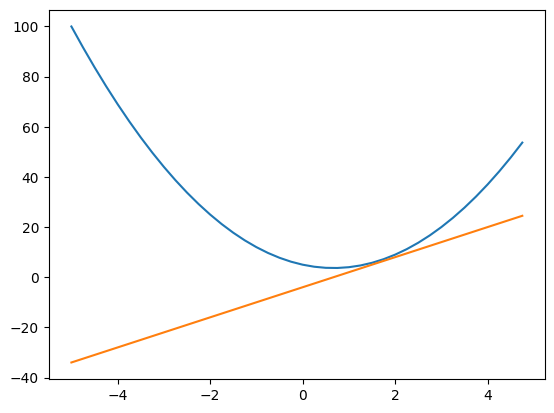

In [56]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
dxs = df(xs)

print(f"X: {xs}\n")
print(f"y: {ys}\n")
print(f"dx: {dxs}\n")

plt.plot(xs, ys)
plt.plot(xs, dxs)

# Multiple Inputs

In [57]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c

In [58]:
h = 0.000001

d1 = a * b + c
a = a + h
d2 = a * b + c

print(f"d1: {d1}\n")
print(f"d2: {d2}\n")
print(f"slope: {(d2 - d1)/h}\n")

d1: 4.0

d2: 3.9999969999999996

slope: -3.000000000419334



# Value Object

In [59]:
class Value:

    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Val(data = {self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), "-")
        return out

In [60]:
v = Value(5, label='v')
v

Val(data = 5)

In [61]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value(-2.0, label='f')
L = e * f
L.label = 'L'
print(L)

Val(data = -8.0)


# Incorporating gradients in Value
--- 
$$ grad \ x |_y  \ = \ \frac{dx}{dy}$$

In [62]:
class Value:

    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # value representation
    def __repr__(self):
        return f"Val(data = {self.data}, grad = {self.grad})"

    # addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    # multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    # subtraction
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    # division
    def __truediv__(self, other):
        return self * other**(-1)

    # negation
    def __neg__(self):
        return self * (-1)

    # power
    def __pow__(self, other):
        assert isinstance(other,
                          (int, float)), "only supports int/ float powers"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad

        out._backward = _backward

        return out

    # exponent
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    # tanh
    def tanh(self):
        z = self.data
        t = (math.exp(2 * z) - 1) / (math.exp(2 * z) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)

        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [63]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value(-2.0, label='f')
L = e * f
L.label = 'L'
print(L)

Val(data = -8.0, grad = 0.0)


## Visualization

In [64]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw(root):
    dgraph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dgraph.node(name=uid,
                    label="{%s | data: %.4f | grad: %.4f }" %
                    (n.label, n.data, n.grad),
                    shape='record')

        if n._op:
            dgraph.node(name=uid + n._op, label=n._op)
            dgraph.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dgraph.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dgraph

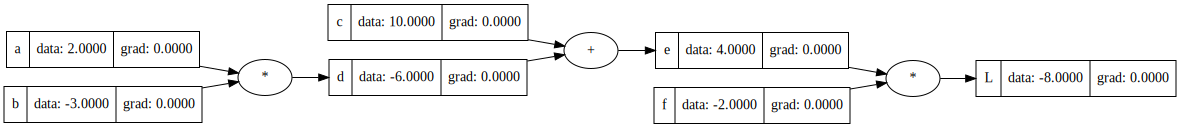

In [65]:
draw(L)

In [66]:
def example():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    d = a * b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    d = a * b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


example()

6.000000000021544


# A Simple Neuron

## Tanh Activation
---
$$ tanh \ x = \frac{e^{2x} - 1}{e^{2x} + 1} $$

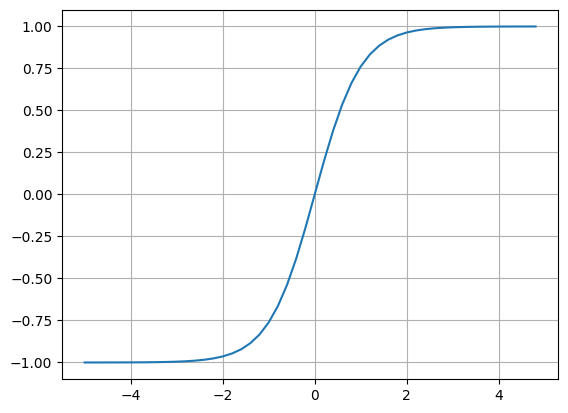

In [67]:
ins = np.arange(-5, 5, 0.2)
outs = np.tanh(np.arange(-5, 5, 0.2))
plt.plot(ins, outs)
plt.grid()

## Neuron Processing
---
$$ z  \ = \ x_1.w_1 \ + \ x_2.w_2 \ + \ b$$
$$ a \  =  \ \sigma(z) \\ where \ \sigma(x) \to tanh(x)$$

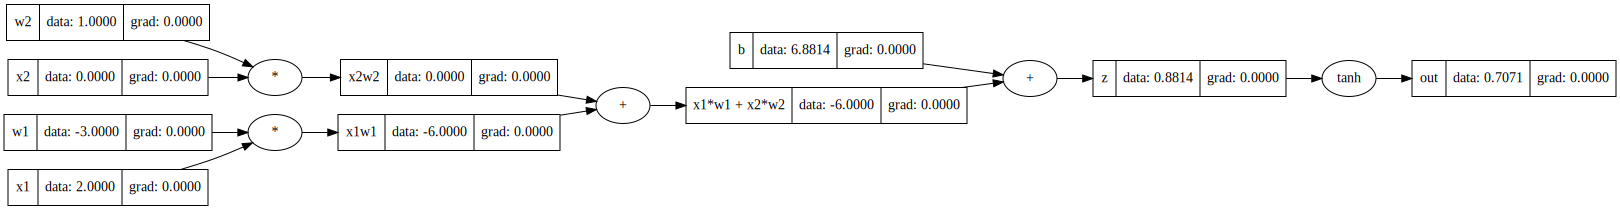

In [76]:
# neuron cell inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")

# neuron weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# neuron bias
b = Value(6.8813735870195432, label="b")

# cumulative neuron input
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

XW = x1w1 + x2w2
XW.label = "x1*w1 + x2*w2"

z = XW + b
z.label = "z"

# activation function
out = z.tanh()
out.label = "out"

draw(out)

## Manual Backpropagation
---
$$ \frac {dz}{dx} \ = \ \frac {dz}{dy} \ .\frac {dy}{dx}$$

In [69]:
# grad of output node (d out/ d out)
out.grad = 1.0

# grad for cumulative input 'z' (d out/ dz)
z.grad = 1 - out.data**2

# grad for bias 'b'
b.grad = z.grad

# grad for weighted input 'XW'
XW.grad = z.grad

# grad for 'x1w1', 'x2w2'
x1w1.grad = XW.grad
x2w2.grad = XW.grad

# grad for 'x2', 'w2'
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

# grad for 'x1', 'w1'
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

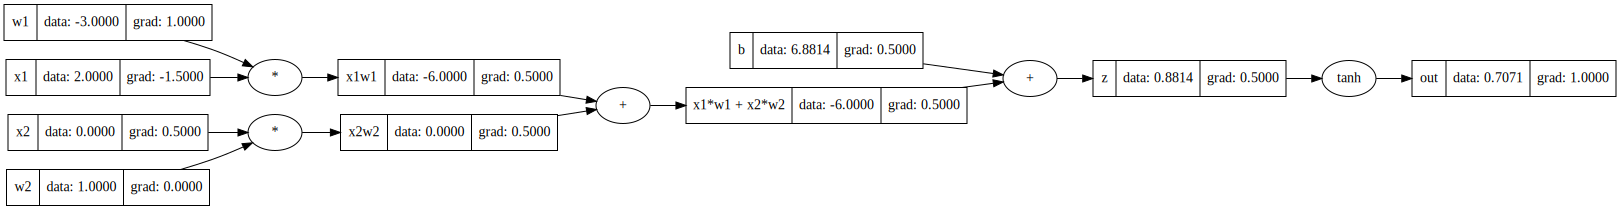

In [70]:
draw(out)

## Integrated local backpropagation
---
<a href="#Neuron-Processing">Neuron Processing</a>

In [72]:
# Rerun neuron processing to reset grad values

# init grad of output to 1.0
out.grad = 1.0

# backpropagation
out._backward()
z._backward()
XW._backward()
x1w1._backward()
x2w2._backward()

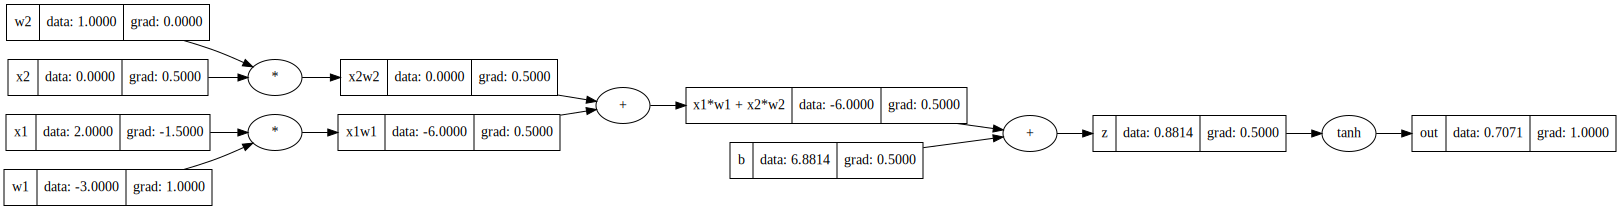

In [73]:
draw(out)

## Topological sort (DAG for backprop)
---
<a href="#Neuron-Processing">Neuron Processing</a>

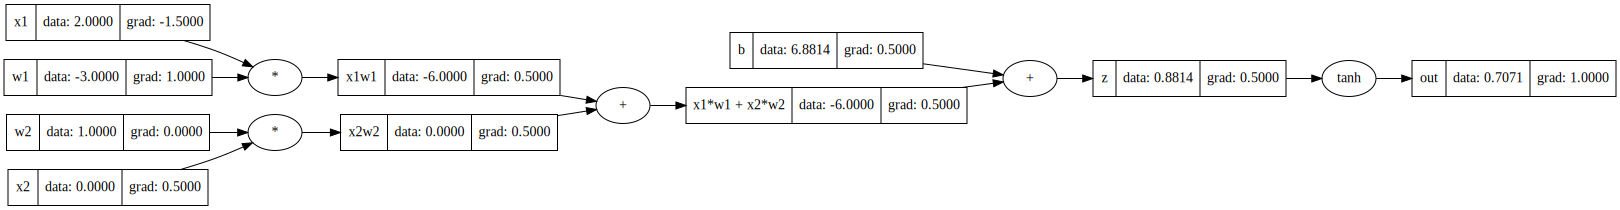

In [75]:
# Rerun neuron processing to reset grad values

# init output grad to 1.0
out.grad = 1.0

# implement topological sort
topo = []
visited = set()


def topo_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topo_sort(child)
        topo.append(v)


topo_sort(out)

# perform backprop on nodes in reverse order
for node in reversed(topo):
    node._backward()

draw(out)

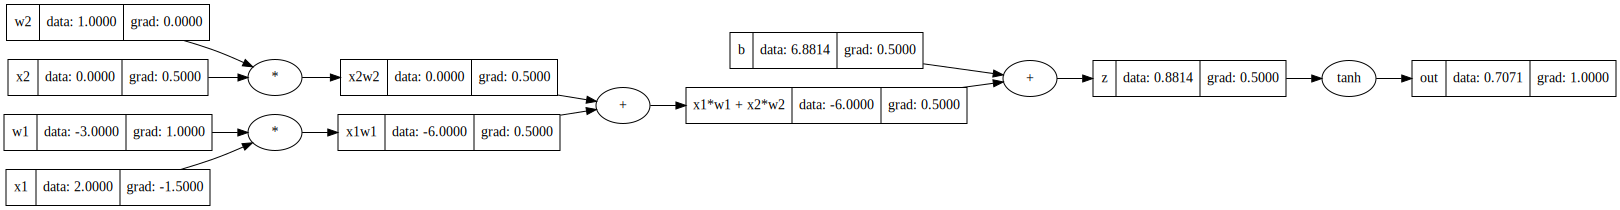

In [77]:
# Rerun neuron processing to reset grad values

out.backward()
draw(out)

## Bug (Backprop gradient overwriting)
--- 
- In the `_backward()` function, we set the gradients of the `self` and `other` instead of accumulating them.   
- This causes a bug during gradient calculation in backpropagation, since the value of a node's gradient is overwritten if its referenced multiple times.   
- To resolve this, we must accumulate the gradients calculated with respect to each of the child nodes, by simple addition.   

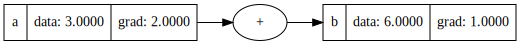

In [78]:
# Bug Resolved Case 1

a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw(b)

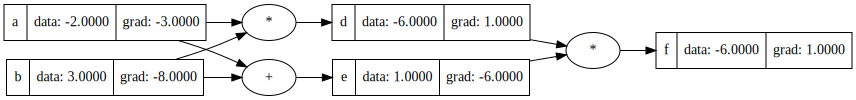

In [79]:
# Bug Resolved Case 2

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'
f.backward()
draw(f)

## Tanh via exponents

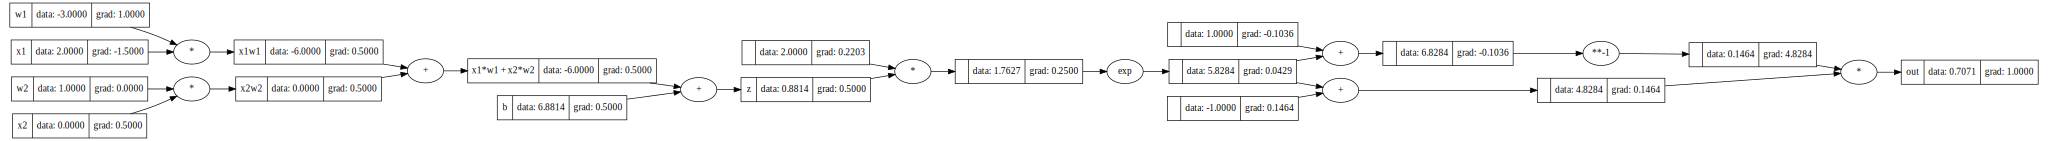

In [80]:
# neuron cell inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")

# neuron weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# neuron bias
b = Value(6.8813735870195432, label="b")

# cumulative neuron input
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

XW = x1w1 + x2w2
XW.label = "x1*w1 + x2*w2"

z = XW + b
z.label = "z"

# activation function
e = (2 * z).exp()
out = (e - 1) / (e + 1)
out.label = "out"

out.backward()

draw(out)

# PyTorch Implementation

In [81]:
import torch

print(torch.__version__)

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

z = w1 * x1 + w2 * x2 + b
out = torch.tanh(z)

print(out.data.item())
out.backward()

print("-----------")
print(f"x1: {x1.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w2: {w2.grad.item()}")

2.1.2+cu121
0.7071066904050358
-----------
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


# Neural Nets

## Neuron

In [82]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        z = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = z.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [83]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Val(data = 0.3455716347035967, grad = 0.0)

## Layer

In [84]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [85]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Val(data = -0.8795888470688271, grad = 0.0),
 Val(data = 0.9906146226997826, grad = 0.0),
 Val(data = -0.7336719355064263, grad = 0.0)]

## MLP

In [86]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [87]:
len(n.parameters())

9

In [88]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Val(data = -0.913903423082037, grad = 0.0)

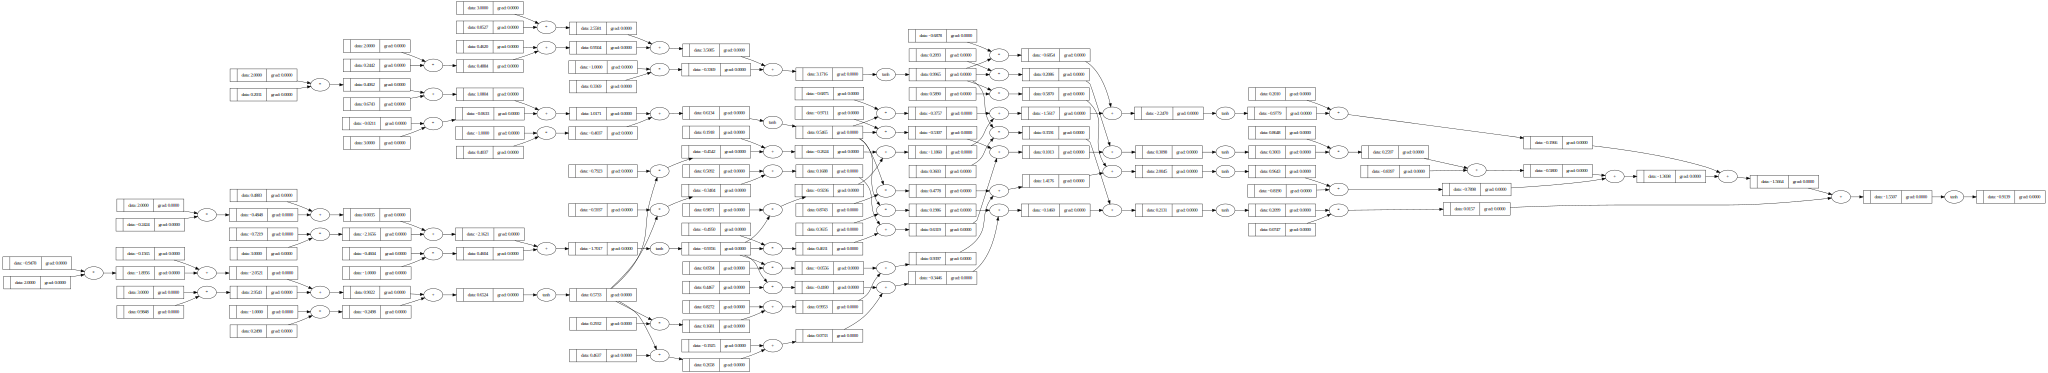

In [89]:
draw(n(x))

## Sample dataset

In [100]:
# sample dataset
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [91]:
y_preds = [n(x) for x in xs]
y_preds

[Val(data = -0.913903423082037, grad = 0.0),
 Val(data = -0.8800306139980885, grad = 0.0),
 Val(data = -0.9539384504485429, grad = 0.0),
 Val(data = -0.854140422427968, grad = 0.0)]

## Loss function
--- 
$$ MSE \ = \ \frac{1}{n}\sum_{i=1}^{n}(Y_i \ - \ \hat{Y_i})^2 $$

In [92]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_preds))
loss

Val(data = 7.117377338891258, grad = 0.0)

In [93]:
loss.backward()

In [94]:
n.layers[0].neurons[0].w[0].grad

0.8641432549637912

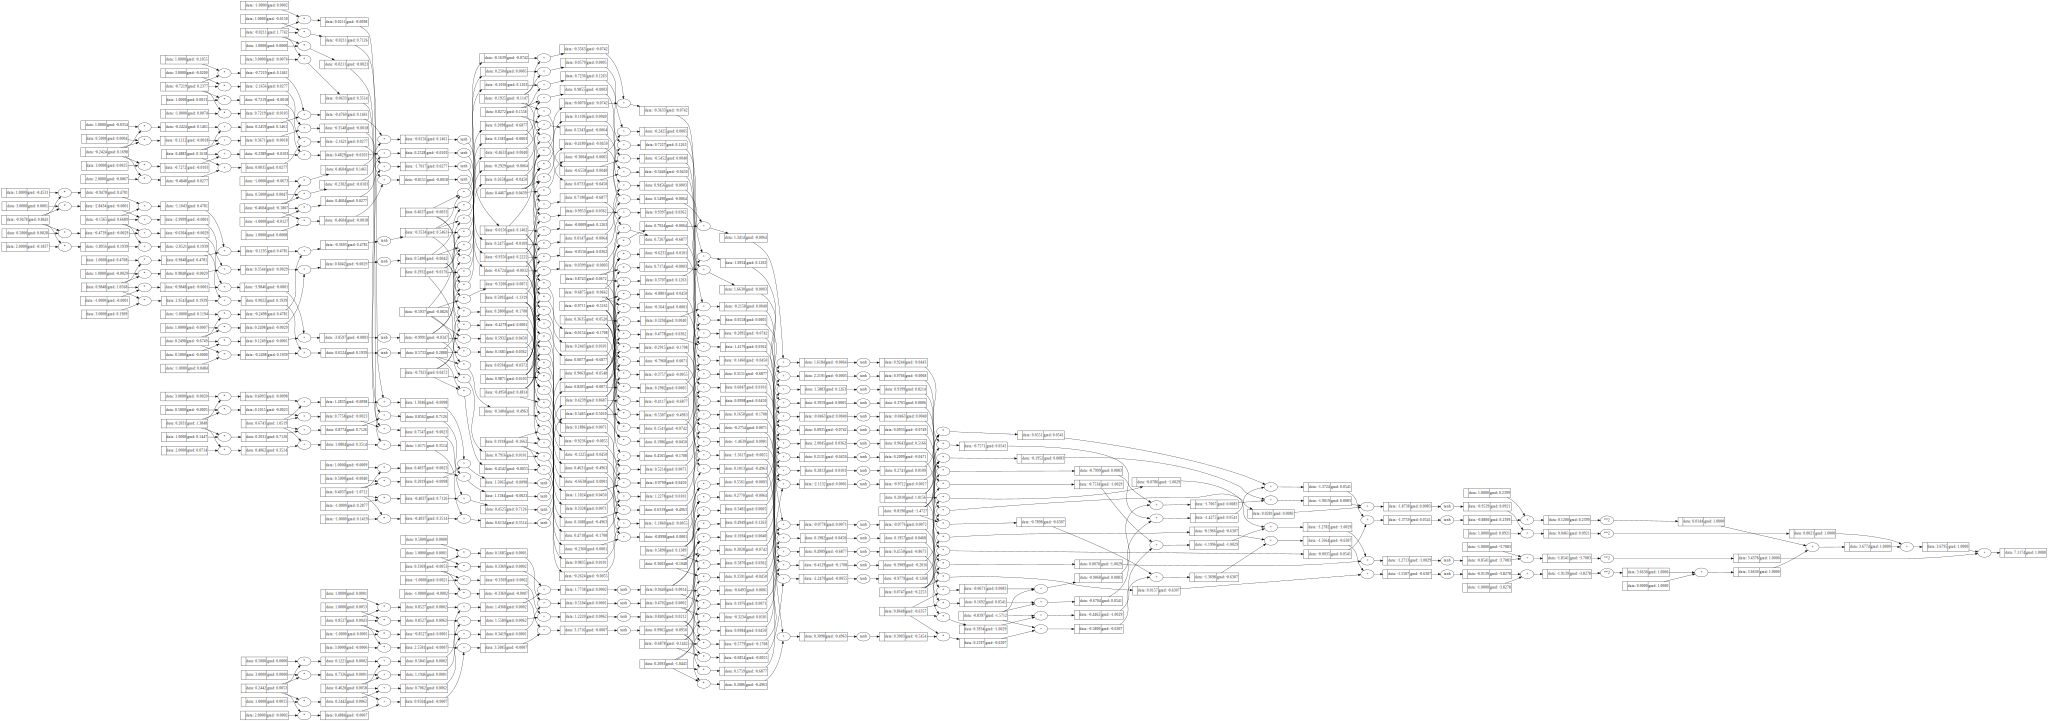

In [95]:
draw(loss)

In [96]:
# updating model parameters

for p in n.parameters():
    p.data += -0.01 * p.grad

# Gradient Descent
---
<a href="#Sample-dataset">Dataset</a>

In [98]:
# rerun sample dataset cell
epochs = 25
lr = 0.05
for k in range(epochs):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

    # backward pass
    loss.backward()

    # parameter update
    for p in n.parameters():
        p.data += -lr * p.grad

    print(k, loss.data)

0 6.904690404389625
1 3.3793860200164745
2 3.8274722979499405
3 3.939883023636275
4 3.3114107936675925
5 2.38921122156372
6 0.12434219919292144
7 0.5943342743670034
8 0.2976581306818138
9 0.013263783928110184
10 0.00039031244253097527
11 6.0695749565657076e-05
12 6.0033761406776434e-05
13 7.583218546008001e-05
14 0.00010244344999852651
15 0.00014263790328845546
16 0.00019704803663522736
17 0.000264258776685699
18 0.00034196495458824135
19 0.00042747675535857694
20 0.000517769898602102
21 0.0006095219057247098
22 0.0006992730627906783
23 0.0007836728013388399
24 0.0008597350195169633


In [99]:
y_pred

[Val(data = 0.9999999999484896, grad = -1.0302070307943723e-10),
 Val(data = -0.9789472313745282, grad = 0.04210553725094357),
 Val(data = -0.979591277533385, grad = 0.04081744493322992),
 Val(data = 0.9999999999484944, grad = -1.0301115516142545e-10)]

## Bug (.zero_grad() before loss.backward()) 
----
- In the code running gradient descent above, we have failed to reset the gradients of the model's weights and biases to 0 before training for the next epoch.
- This means that the gradients of the weights and biases get accumulated during training.
- To resolve this, we must ensure to set the gradients of the model parameters to 0.0 before performing backward pass (`.backward()`) on the loss.
---
<a href="#Sample-dataset">Dataset</a>

In [101]:
# debugged code

# rerun sample dataset cell 
epochs = 25
lr = 0.05
for k in range(epochs):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
    
    # Bug Fix: zero_grad()
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()

    # parameter update
    for p in n.parameters():
        p.data += -lr * p.grad

    print(k, loss.data)

0 0.0009250440301734862
1 0.0009211294353725266
2 0.0009172481792050168
3 0.0009133998351861523
4 0.0009095839841004794
5 0.0009058002138472216
6 0.0009020481192896735
7 0.0008983273021083416
8 0.0008946373706577358
9 0.0008909779398269176
10 0.0008873486309033795
11 0.000883749071440408
12 0.0008801788951277166
13 0.0008766377416652698
14 0.0008731252566402329
15 0.0008696410914069018
16 0.0008661849029696312
17 0.0008627563538684776
18 0.0008593551120678084
19 0.0008559808508473955
20 0.0008526332486962948
21 0.000849311989209126
22 0.0008460167609849268
23 0.0008427472575283189
24 0.0008395031771531291


# References   
---
- YouTube: [Building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)   
- GitHub: [micrograd](https://github.com/karpathy/micrograd)